# Plot

You hopefully don't need to edit this block, but further customization can be hardcoded here.       

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import atlas_mpl_style
import colorsys
import numpy as np
atlas_mpl_style.use_atlas_style(fancyLegend=True)

In [26]:
def darken(c, value=3):
    rgba = mcolors.to_rgba(c)
    h,l,s = colorsys.rgb_to_hls(*rgba[:3])
    new_rgb = colorsys.hls_to_rgb(h, min(1, l/value), s)
    return [*new_rgb, rgba[3]]

def plot(vals, styles, filename='ef08plot', legend_nrow=2, xlabel='Mass Reach', ylabel='Search Method', title=None, **kwargs):
    '''
    @param vals:
        A dictionary of group:data, with each entry corresponding to a group of bars
        in top to bottom order. The group name is shown on the y-label. 

        `data` should be a dictionary containing entries collider:[limit, reference], 
        in top to bottom order. `limit` can also be a tuple (min, mid, max) to show a range. 

        `data` can also have optional entries 
            - 'annotation': An annotation is added to the group label
            - 'current limits': A value for the current limit, which is drawn as a vertical bar
    @param styles:
        A dictionary of collider:opts, where the colliders correspond to those
        in `vals`. The order here is the order they appear in the legend. `opts`
        is a dictionary of options to Axes.barh. You can optionally also include
        a style option 'annotation':annotation, which will append the annotation
        to the legend description.

        Note that an option, if used, must be specified for all colliders.

        https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.axes.Axes.barh.html
    '''
    ### Setup and collections ###
    fig, ax = plt.subplots()
    fig.set_dpi(144)

    bar_height = 1 # height of a bar in data coordinates (keep this at 1)
    group_pad = 0.5 # space between groups in data coordinates
    reference_pad = 0.05 # in axes coordinates

    # y-groups (search method)
    labels = [] # string labels for each group
    label_ys = [] # y position of the labels
    dividers = [] # y positions of where to draw dividers between the groups
    curr_lims = [] # (x, y0, y1) positions of the current limits

    # bars
    ys = [] # y position of each bar (lower edge)
    widths = [] # width of each bar
    heights = [] # height of each bar
    references = [] # string reference of each bar
    ranges = [] # list of (y, xmin, xmax) of where to plot a hatching indicating a range of values
    opts = {} # option : list per bar

    # legend
    legend_indexes = {} # collider : index into bars.patches
    last_var = '' # if there are darkened bars for variations, collider name with last variation

    ### Collate info ###
    y = 0 # Loop from top to bottom (y-axis will be inverted, so start at y=0 and go up).
    for i,(group,colliders) in enumerate(vals.items()):
        y_group_start = y

        ### Collider bars ###
        for collider,limits in colliders.items():
            if collider in ['annotation', 'current limits']:
                continue
            if isinstance(limits, dict):
                if x := limits.get('alt val'): # this goes under the top bar, so must be first
                    last_var = collider
                    heights.append(bar_height)
                    widths.append(x)
                    references.append('')
                    ys.append(y)
                    for opt,opt_val in styles[collider].items():
                        if opt != 'annotation':
                            opts.setdefault(opt, []).append(opt_val)
                    opts['color'][-1] = darken(opts['color'][-1], 3)
                heights.append(bar_height)
                widths.append(limits['val'])
                references.append(limits.get('ref', ''))
                if r := limits.get('range'): ranges.append((y, *r))
                ys.append(y)
                legend_indexes.setdefault(collider, len(ys) - 1)
                for opt,opt_val in styles[collider].items():
                    if opt != 'annotation':
                        opts.setdefault(opt, []).append(opt_val)
            else: # backwards compatability
                heights.append(bar_height)
                if hasattr(limits[0], '__getitem__'): # plot a range
                    widths.append(limits[0][1])
                    ranges.append((y, limits[0][0], limits[0][2]))
                else:
                    widths.append(limits[0])
                references.append(limits[1])
                ys.append(y)
                for opt,opt_val in styles[collider].items():
                    if opt != 'annotation':
                        opts.setdefault(opt, []).append(opt_val)
                legend_indexes.setdefault(collider, len(ys) - 1)
            y += bar_height

        ### Group info ###
        if annotation := colliders.get('annotation'):
            group += '\n' + annotation
        labels.append(group)
        label_ys.append((y + y_group_start) / 2)
        dividers.append(y + group_pad / 2)
        if lim := colliders.get('current limits'):
            curr_lims.append((lim, 0 if len(dividers) < 2 else dividers[-2], y if i == len(vals) - 1 else dividers[-1]))
        y += group_pad
    dividers = dividers[:-1] # don't draw a divider after the last group

    ### Set figure size ###
    if figsize := kwargs.get('figsize'):
        fig.set_size_inches(figsize)
    else:
        fig.set_size_inches(10, ys[-1]/2.+bar_height) # to keep bar width roughly the same.

    ### Auto-set hatch color ###
    if 'color' in opts and 'hatch' in opts and 'edgecolor' not in opts:
        opts['edgecolor'] = [darken(c) for c in opts['color']]

    ### Plot main bars ###
    bars = ax.barh(y=ys, width=widths, height=heights, align='edge', **opts)
    ax.set_yticks(label_ys, labels)
    ax.tick_params(axis='y', which='minor', left=False, right=False)
    ax.set_ylim(0, ys[-1] + bar_height)
    ax.invert_yaxis()
    atlas_mpl_style.set_xlabel(xlabel)
    atlas_mpl_style.set_ylabel(ylabel)

    ### Plot range overlays ###
    for y,x0,x1 in ranges:
        patch_range = mpatches.Rectangle((x0, y), x1 - x0, bar_height, hatch='////', linestyle='', edgecolor='#00000077', fill=False)
        ax.add_patch(patch_range)

    ### Plot current limits ###
    for x,y0,y1 in curr_lims:
        lim_line = ax.plot([x, x], [y0, y1], linestyle='-', linewidth=3, color='#333333')

    ### Plot and get x extent of references ###
    x0,x1 = ax.get_xlim()
    max_text_width = 0 # in axes coordinates
    text_height = 0 # in axes coordinates
    patch_references = []
    for y,ref in zip(ys, references):
        if not ref: continue
        t = ax.text(x1, y + bar_height/2, ref, va='center', ha='center')
        bb = t.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        max_text_width = max(max_text_width, bb.x1 - bb.x0)
        text_height = bb.y1 - bb.y0
        patch_references.append(t)
        # https://stackoverflow.com/questions/24581194/matplotlib-text-bounding-box-dimensions
    data_to_axis = ax.transData + ax.transAxes.inverted()
    for patch in patch_references: # adjust x position
        pos = list(data_to_axis.transform(patch.get_position())) # axis coordinates, with x = 1 currently
        pos[0] += reference_pad + max_text_width / 2
        pos = data_to_axis.inverted().transform(pos)
        patch.set_position(pos)
    text_height = text_height or 0.9 / (3 + len(ys))

    ### Plot dividers ###
    for y in dividers:
        offset = 2 * reference_pad + max_text_width if max_text_width else 0
        ax.axhline(y, xmax=1 + offset, linestyle='--', color='#666666', clip_on=False)

    ### Plot legend ###
    legend_patches = []
    legend_labels = []
    if curr_lims:
        legend_patches.append(lim_line[0])
        legend_labels.append('LHC Limits')
    if ranges:
        legend_patches.append(patch_range)
        legend_labels.append('Range of estimates')
    for collider,opts in styles.items():
        if (index := legend_indexes.get(collider)) is not None:
            legend_patches.append(bars.patches[index])
            if label := opts.get('label'):
                legend_labels.append(label)
            elif annotation := opts.get('annotation'):
                legend_labels.append(collider + ' ' + annotation)
        if last_var == collider:
            legend_patches.append(mpatches.Rectangle((0, 0), 1, 1, facecolor='#333333'))
            legend_labels.append('ILC Indirect Limits')
    legend = ax.legend(legend_patches, legend_labels, loc='upper center', bbox_to_anchor=((1 + max_text_width) / 2, -2.5*text_height), framealpha=1, edgecolor='white', handleheight=1.4, ncol=(len(legend_labels)+legend_nrow-1)//legend_nrow)

    ### Add title ###
    ax.set_title(title)

    ### Save ###
    plt.savefig(filename + '.pdf', bbox_inches='tight')


# Inputs

Edit and/or run the cell with the data and configuration you want. See the docstring of `plot` for descriptions of the input variables.

In [70]:
### SQUARK ###

vals = {
    '8 squarks': {
        'HL-LHC': [2.5, 'CR extrapolation from CMS Run 2'],
        'HL-LHC': [2.6, 'CR extrapolation from ATLAS Run 2'],
        'FCC-hh': [14.4, 'CR extrapolation from CMS Run 2'],
        'annotation': r'$m(\chi) = 0$',
        'current limits': 1.66,
    },
    '1 squark': {
        'HL-LHC': [1.8, 'CR extrapolation from CMS Run 2'],
        'HL-LHC': [1.9, 'CR extrapolation from ATLAS Run 2'],
        'FCC-hh': [10, 'CR extrapolation from CMS Run 2'],
        'annotation': r'$m(\chi)=0$',
        'current limits': 1.1,
    },
}

cmap = mcm.get_cmap('Set3')
styles = {
    'HL-LHC': {'annotation':'14 TeV, 3 ab$^{-1}$', 'color':cmap(0), 'hatch':None},
    'FCC-hh': {'annotation':'100 TeV, 30 ab$^{-1}$', 'color':cmap(7), 'hatch':'/'},
    'ILC': {'annotation':'0.5 TeV, 4 ab$^{-1}$', 'color':cmap(3), 'hatch':'-'},
    'CLIC': {'annotation':'3 TeV, 5 ab$^{-1}$', 'color':cmap(4), 'hatch':'|'},
    'FCC-ee': {'annotation':'0.35 TeV, 12.6 ab$^{-1}$', 'color':cmap(2), 'hatch':'+'},
    'CEPC': {'annotation':'0.24 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'x'},
}

opts = {
    'filename': 'squark',
    'xlabel': r'$m(\widetilde{q}_1)$ [GeV]',
}


In [24]:
### STOP ###

vals = {
    '2-body': {
        'HL-LHC': [(1.7, 1.7, 2.56), 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [(10.8, 10.8, 12.5), 'CERN-ACC-2018-0056'],
        'ILC500': [0.25, '$\\sqrt{s}/2$'],
        'CLIC': [1.5, 'CERN-ESU-004'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
        'annotation': r'$\widetilde{t}_1 \to t\widetilde{\chi}_1^0$',
        'current limits': 1.25,
    },
    '3-body': {
        'HL-LHC': [(0.85, 0.85, 1.56), 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [(7.37, 10, 10), 'CERN-ACC-2018-0056'],
        'ILC500': [0.25, '~$\\sqrt{s}/2$'],
        'CLIC': [1.5, 'CERN-ESU-004'],
        'Muon10': [5, '~$\\sqrt{s}/2$'],
        'Muon30': [15, '~$\\sqrt{s}/2$'],
        'annotation': r'$\widetilde{t}_1 \to bW\widetilde{\chi}_1^0$',
        'current limits': 0.75,
    },
    '4-body': {
        'HL-LHC': [(0.95, 1.41, 1.41), 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [(5, 5, 6.64), 'CERN-ACC-2019-0036'],
        'ILC500': [0.25, '~$\\sqrt{s}/2$'],
        'CLIC': [1.5, 'CERN-ESU-004$'],
        'Muon10': [5, '~$\\sqrt{s}/2$'],
        'Muon30': [15, '~$\\sqrt{s}/2$'],
        'annotation': r"$\widetilde{t}_1 \to bff'\widetilde{\chi}_1^0$",
        'current limits': 0.625,
    },
    'Precision\nHiggs': {
        'HL-LHC': [.475, '1707.03399'],
        'ILC500': [0.875, '1707.03399'],
        'CEPC': [0.8, '1707.03399'],
        'FCC-ee': [1, '1707.03399'],
        'current limits': 0.425,
    },
}


cmap = mcm.get_cmap('Set3')
styles = {
    'HL-LHC': {'annotation':'14 TeV, 3 ab$^{-1}$', 'color':cmap(0), 'hatch':None},
    'HE-LHC': {'annotation':'27 TeV, 15 ab$^{-1}$', 'color':cmap(1), 'hatch':'\\'},
    'FCC-hh': {'annotation':'100 TeV, 30 ab$^{-1}$', 'color':cmap(7), 'hatch':'/'},
    'ILC500': {'label':'ILC 0.5 TeV, 4 ab$^{-1}$', 'color':cmap(3), 'hatch':'--'},
    'ILC1000': {'label':'ILC 1 TeV, 4 ab$^{-1}$', 'color':cmap(9), 'hatch':'--.'},
    'CLIC': {'annotation':'3 TeV, 5 ab$^{-1}$', 'color':cmap(4), 'hatch':'|'},
    'CEPC': {'annotation':'0.24 TeV, 10 ab$^{-1}$', 'color':cmap(10), 'hatch':'x'},
    'FCC-ee': {'annotation':'0.35 TeV, 12.6 ab$^{-1}$', 'color':cmap(2), 'hatch':'+'},
    'Muon10': {'label': 'Muon 10 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'o'},
    'Muon30': {'label': 'Muon 30 TeV, 10 ab$^{-1}$', 'color':cmap(6), 'hatch':'.'},
}

opts = {
    'filename': 'stop',
    'title': "Snowmass 2021: Collider Sensitivity to Stop Quarks",
    'xlabel': r'$m(\widetilde{t}_1)$ [TeV]',
    'figsize': (14, 11),
    'legend_nrow': 4,
}

In [17]:
### SMUON ###

vals = {
    'Displaced': {
        'HL-LHC': [1.37, 'LHC Run-2 Re-scaled'],
        'HE-LHC': [2.75, 'LHC Run-2 Re-scaled'],
        'FCC-hh': [6.75, 'LHC Run-2 Re-scaled'],
        'Muon3': [1.5, '$\\sqrt{s}/2$'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
        'annotation': r'$\tau=0.1$ ns',
        'current limits': .680,
    },
    r'$\Delta m(\widetilde{\mu}, \widetilde{\chi}^0_1)$'"\n$=10$ GeV": {
        'HL-LHC': [0.53, 'LHC Run-2 Re-scaled'],
        'HE-LHC': [1.09, 'LHC Run-2 Re-scaled'],
        'FCC-hh': [2.46, 'LHC Run-2 Re-scaled'],
        'Muon3': [1.5, '$\\sqrt{s}/2$'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
        'current limits': .225,
    },
    r'$\Delta m(\widetilde{\mu}, \widetilde{\chi}^0_1)$'"\n$=200$ GeV": {
        'HL-LHC': [1.17, 'LHC Run-2 Re-scaled'],
        'HE-LHC': [2.36, 'LHC Run-2 Re-scaled'],
        'FCC-hh': [5.66, 'LHC Run-2 Re-scaled'],
        'Muon3': [1.5, '$\\sqrt{s}/2$'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
        'current limits': .56,
    },
}

cmap = mcm.get_cmap('Set3')
styles = {
    'HL-LHC': {'annotation':'14 TeV, 3 ab$^{-1}$', 'color':cmap(0), 'hatch':None},
    'HE-LHC': {'annotation':'27 TeV, 15 ab$^{-1}$', 'color':cmap(1), 'hatch':'\\'},
    'FCC-hh': {'annotation':'100 TeV, 30 ab$^{-1}$', 'color':cmap(7), 'hatch':'/'},
    'ILC': {'annotation':'0.5 TeV, 4 ab$^{-1}$', 'color':cmap(3), 'hatch':'-'},
    'CLIC': {'annotation':'3 TeV, 5 ab$^{-1}$', 'color':cmap(4), 'hatch':'|'},
    'FCC-ee': {'annotation':'0.35 TeV, 12.6 ab$^{-1}$', 'color':cmap(2), 'hatch':'+'},
    'CEPC': {'annotation':'0.24 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'x'},
    'Muon3': {'label': 'Muon 3 TeV, 10 ab$^{-1}$', 'color':cmap(8), 'hatch':'o.'},
    'Muon10': {'label': 'Muon 10 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'o'},
    'Muon30': {'label': 'Muon 30 TeV, 10 ab$^{-1}$', 'color':cmap(6), 'hatch':'.'},
}

opts = {
    'filename': 'smuon',
    'title': "Snowmass 2021: Collider Sensitivity to Smuons",
    'xlabel': r'$m(\widetilde{\mu})$ [TeV]',
    'legend_nrow': 3,
}

In [21]:
### STAU ###

vals = {
    r'$\Delta m(\widetilde{\tau}, \widetilde{\chi}^0_1)$'"\n$=10$ GeV": {
        'HE-LHC': [.176, 'CERN-LPCC-2018-05'],
        'FCC-hh': [.392, 'HE-LHC Re-scaled'],
        'ILC': [0.25, '2203.15729'],
        'Muon3': [1.5, '$\\sqrt{s}/2$'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
    },
    r'$\Delta m(\widetilde{\tau}, \widetilde{\chi}^0_1)$'"\n$=100$ GeV": {
        'HL-LHC': [[.207, .27, .373], 'CMS-PAS-FTR-18-010'],
        'HE-LHC': [.767, 'LHC Run-2 Re-scaled'],
        'FCC-hh': [1.748, 'LHC Run-2 Re-scaled'],
        'ILC': [0.25, '2203.15729'],
        'CLIC': [1.25, 'CERN-ESU-004'],
        'Muon3': [1.5, '$\\sqrt{s}/2$'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
        'current limits': .163,
    },
    r'$\Delta m(\widetilde{\tau}, \widetilde{\chi}^0_1)$'"\n$>400$ GeV": {
        'HL-LHC': [[.638, .638, .679], 'CMS-PAS-FTR-18-010'],
        'HE-LHC': [[1.116,2.621,2.751], 'HL-LHC Re-scaled'],
        'FCC-hh': [[6.375,6.375,6.745], 'HL-LHC Re-scaled'],
        'ILC': [0.25, '2203.15729'],
        'Muon3': [1.5, '$\\sqrt{s}/2$'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
    },
}

cmap = mcm.get_cmap('Set3')
styles = {
    'HL-LHC': {'annotation':'14 TeV, 3 ab$^{-1}$', 'color':cmap(0), 'hatch':None},
    'HE-LHC': {'annotation':'27 TeV, 15 ab$^{-1}$', 'color':cmap(1), 'hatch':'\\'},
    'FCC-hh': {'annotation':'100 TeV, 30 ab$^{-1}$', 'color':cmap(7), 'hatch':'/'},
    'ILC': {'annotation':'0.5 TeV, 4 ab$^{-1}$', 'color':cmap(3), 'hatch':'-'},
    'CLIC': {'annotation':'3 TeV, 5 ab$^{-1}$', 'color':cmap(4), 'hatch':'|'},
    'FCC-ee': {'annotation':'0.35 TeV, 12.6 ab$^{-1}$', 'color':cmap(2), 'hatch':'+'},
    'CEPC': {'annotation':'0.24 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'x'},
    'Muon3': {'label': 'Muon 3 TeV, 10 ab$^{-1}$', 'color':cmap(8), 'hatch':'o.'},
    'Muon10': {'label': 'Muon 10 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'o'},
    'Muon30': {'label': 'Muon 30 TeV, 10 ab$^{-1}$', 'color':cmap(6), 'hatch':'.'},
}

opts = {
    'filename': 'stau',
    'title': "Snowmass 2021: Collider Sensitivity to Staus",
    'xlabel': r'$m(\widetilde{\tau})$ [TeV]',
    'legend_nrow': 4,
}

In [7]:
### SUMMARY ###

vals = {
    'strong production\nhigh mass splitting\nstop 2-body': {
        'HL-LHC': [(1.7, 1.7, 2.56), 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [(10.8, 10.8, 12.5), 'CERN-ACC-2018-0056'],
        'ILC500': [0.25, '$\\sqrt{s}/2$'],
        'CLIC': [1.5, 'CERN-ESU-004'],
        'Muon10': [5, '$\\sqrt{s}/2$'],
        'Muon30': [15, '$\\sqrt{s}/2$'],
        'current limits': 1.25,
    },
    'strong production\nlow mass splitting\nstop 4-body': {
        'HL-LHC': [(0.95, 1.41, 1.41), 'ATL-PHYS-PUB-2018-021'],
        'FCC-hh': [(5, 5, 6.64), 'CERN-ACC-2019-0036'],
        'ILC500': [0.25, '~$\\sqrt{s}/2$'],
        'CLIC': [1.5, 'CERN-ESU-004'],
        'Muon10': [5, '~$\\sqrt{s}/2$'],
        'Muon30': [15, '~$\\sqrt{s}/2$'],
        'current limits': 0.625,
    },
    'stop from\nprecision Higgs': {
        'HL-LHC': [.475, '1707.03399'],
        'ILC500': [0.875, '1707.03399'],
        'CEPC': [0.8, '1707.03399'],
        'FCC-ee': [1, '1707.03399'],
        'current limits': 0.425,
    },
    'weak production\nhigh mass splitting\nWino-Bino\n$\\Delta M<750$ GeV': {
        'current limits': 0.96, # arxiv: 2108.07586
        'HL-LHC': [[1.59,1.625,1.66], 'CMS-PAS-FTR-22-001'],
        'HE-LHC': [3.27, 'Run-2 Extrapolation'],
        #'FCC-hh (3/ab)': [5.84, 'Run-2 Extrapolation'],
        #'ESR FCC_hh 3L': [4.15, '1410.6287'],
        'FCC-hh': [8.80, 'Run-2 Extrapolation'],
        'ILC500': {'val':0.25, 'alt val':.45, 'ref':'~$\\sqrt{s}/2$, 1504.03402'},
        'ILC1000': {'val':0.5, 'alt val':.70, 'ref':'~$\\sqrt{s}/2$, 1504.03402'},
        'CLIC': [1.5, '~$\\sqrt{s}/2$'],
        #'Muon 3': [1.5, '~$\\sqrt{s}/2$'],
        'Muon10': [5, '~$\\sqrt{s}/2$'],
        'Muon30': [15, '~$\\sqrt{s}/2$'],
        #'annotation': r'$\widetilde{\chi}_2^0/\widetilde{\chi}_1^{\pm} \to t\widetilde{\chi}_1^0$,qq',
        #'ESR HL-LHC': [0.886, 'ATL-PHYS-PUB-2018-048'],
    },
    'weak production\nsmall mass splitting\nHiggsino\n$\\Delta M=5$ GeV': {
        'current limits': .18,
        'HL-LHC': [.42, 'Run-2 Extrapolation'],
        'HE-LHC': [.8, 'Run-2 Extrapolation'],
        'FCC-hh': [1.95, 'Run-2 Extrapolation'],
        'ILC500': {'val':0.25, 'alt val':.325, 'ref':'~$\\sqrt{s}/2$, 1504.03402'},
        'ILC1000': {'val':0.5, 'alt val':.575, 'ref':'~$\\sqrt{s}/2$, 1504.03402'},
        'CLIC': [1.5, r'~$\sqrt{s}/2$'],
        'Muon10': [5, '~$\\sqrt{s}/2$'],
        'Muon30': [15, '~$\\sqrt{s}/2$'],
    },
}


cmap = mcm.get_cmap('Set3')
styles = {
    'HL-LHC': {'annotation':'14 TeV, 3 ab$^{-1}$', 'color':cmap(0), 'hatch':None},
    'HE-LHC': {'annotation':'27 TeV, 15 ab$^{-1}$', 'color':cmap(1), 'hatch':'\\'},
    'FCC-hh': {'annotation':'100 TeV, 30 ab$^{-1}$', 'color':cmap(7), 'hatch':'/'},
    'ILC500': {'label':'ILC 0.5 TeV, 4 ab$^{-1}$', 'color':cmap(3), 'hatch':'--'},
    'ILC1000': {'label':'ILC 1 TeV, 4 ab$^{-1}$', 'color':cmap(9), 'hatch':'--.'},
    'CLIC': {'annotation':'3 TeV, 5 ab$^{-1}$', 'color':cmap(4), 'hatch':'|'},
    'CEPC': {'annotation':'0.24 TeV, 10 ab$^{-1}$', 'color':cmap(10), 'hatch':'x'},
    'FCC-ee': {'annotation':'0.35 TeV, 12.6 ab$^{-1}$', 'color':cmap(2), 'hatch':'+'},
    'Muon10': {'label': 'Muon 10 TeV, 10 ab$^{-1}$', 'color':cmap(5), 'hatch':'o'},
    'Muon30': {'label': 'Muon 30 TeV, 10 ab$^{-1}$', 'color':cmap(6), 'hatch':'.'},
}


opts = {
    'filename': 'EF_summary',
    'title': "Snowmass 2021: Energy Frontier Collider Sensitivities",
    'xlabel': r'Mass Reach [TeV]',
    'figsize': (10, 12),
    'legend_nrow': 5,
}

# Run

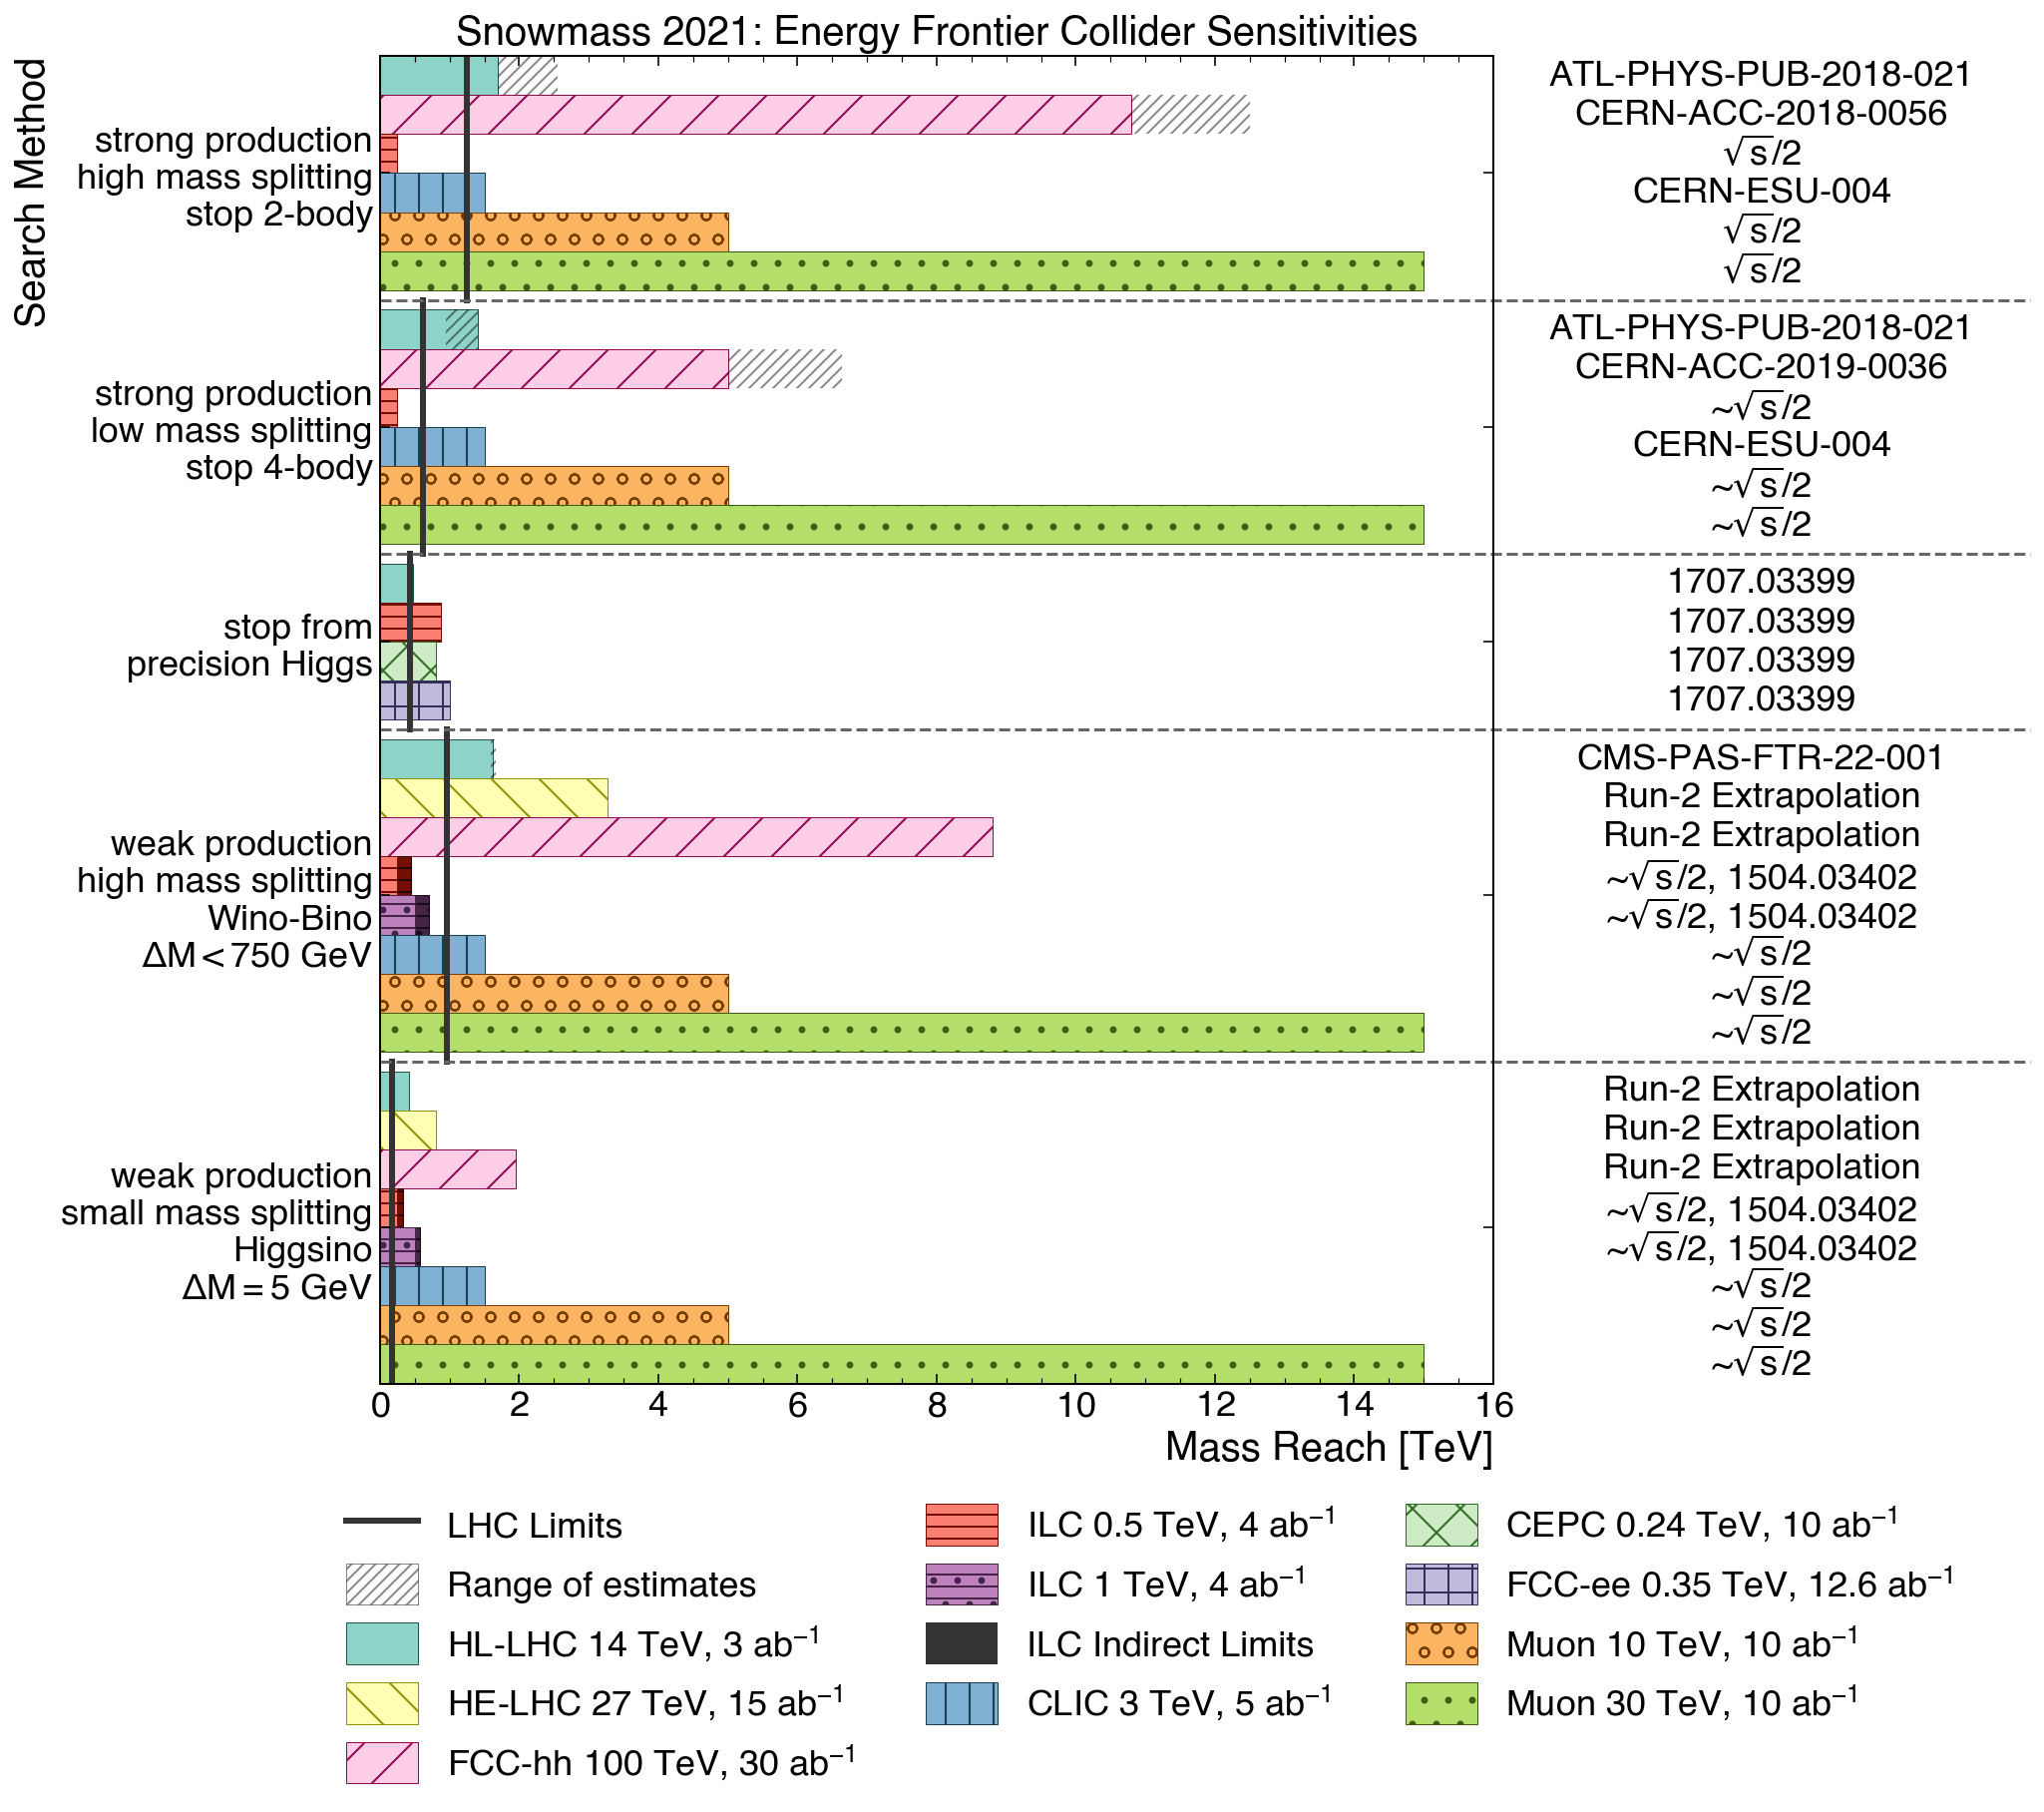

In [27]:
# Run me after choosing the input cell above
fig = plot(vals, styles, **opts)

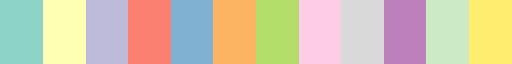

In [4]:
cmap